---
title: "03: Image Classification (CIFAR-10)"
author: "Thomas Manke"
date:  "2023-11-03"
categories:
  - CNN
  - Tensorflow/Keras
  - Evaluation
format:
  html:
    code-fold: true
description: "**Ziel**: Benutze und Interpretiere Deep Neural Networks"
image: "images/Sherlock.png"
---

# Get Libraries

In [2]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
print('tf-version: ', tf.__version__)

tf-version:  2.15.0


# Challenges from previous work (MNIST)






<div>
   <img src="https://github.com/thomasmanke/ABS/raw/main/figures/smileys.png",  width="500">
</div>

- training (and test) data were highly structured: fixed size, grey scale, item centered, only single item 



**Discussion**: other possible challenges?



- spatially distributed features
- view point
- illumination
- deformation
- occlusion, 
- intraclass variation



Algorithms should be 

- robuts to those changes within one class (e.g. cat)
- generic and transferable to all other classes 
- interpretable

# A short history

Algorithms, Compute Power, Data, Data & Data

- 1958 Rosenblatt: The perceptron: A probabilistic Model for Information Storage and  Organization in the Brain.
- 1998 Le Cun et al.  (MNIST):  60000 images of 10 handwritten digits ($10^7$ pixels) + CPU ($10^6$ transitors)
- 2012 Alex Krizhevsky et al (ImageNet): 1.3M images for 1000 classes ($10^{14}$ pixels) + GPU ($10^9$ transistors)
- 2021 Yang et al. (MedMNIST): 700k images for 2-11 classes 
https://github.com/MedMNIST/MedMNIST
- 2022 Google Open Images v6: 60M images, 20000 classes: https://storage.googleapis.com/openimages/web/index.html



# Another classical dataset: CIFAR-10

This is a set of 50k images in 10 categories.
They are rather coarse (32 x 32), but unlike MNIST and MNIST-Fashion they are not as standardized.



In [3]:
# cell takes 1-2 minutes (on my regular home network)
cifar10 = tf.keras.datasets.cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

### downsampling to avoid kernel crashes with small RAM (e.g Binder)
n_down = 10000
n_down_test = int(n_down/5)

if (n_down>0):
  np.random.seed(42)
  print('train-before:', X_train.shape, y_train.shape)
  print('test-before: ', X_test.shape, y_test.shape)
  id_train = np.random.choice(X_train.shape[0],n_down)
  id_test  = np.random.choice(X_test.shape[0],n_down_test)
  X_train, y_train = X_train[id_train, ...], y_train[id_train, ...]
  X_test, y_test = X_test[id_test, ...], y_test[id_test, ...]
  print('train-before:', X_train.shape, y_train.shape)
  print('test-before: ', X_test.shape, y_test.shape)

# normalization
X_train, X_test = X_train / 255.0, X_test / 255.0

# just for easier reference to replace integers with names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

train-before: (50000, 32, 32, 3) (50000, 1)
test-before:  (10000, 32, 32, 3) (10000, 1)
train-before: (10000, 32, 32, 3) (10000, 1)
test-before:  (2000, 32, 32, 3) (2000, 1)


**Task (10 min)**:  

Determine the shape of the data and store it for latter use. Explore the data set and have a look at different images.

X_train - shape: (10000, 32, 32, 3)
y_train - shape  (10000, 1)


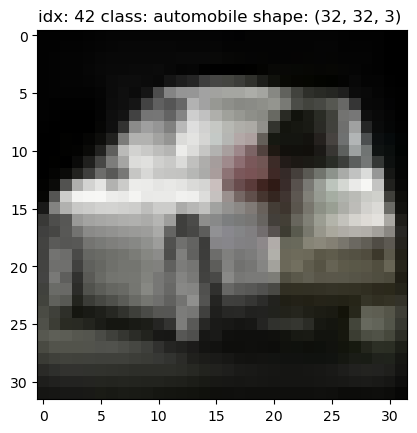

In [4]:
xtrain_s = X_train.shape # edit
ytrain_s = y_train.shape # edit
print('X_train - shape:', xtrain_s ) 
print('y_train - shape ', ytrain_s)     

idx=42                             # make your choice
cn=class_names[y_train[idx][0]]
plt.imshow(X_train[idx]) 
plt.title('idx: {} class: {} shape: {} '.format(idx, cn, X_train[idx].shape))
plt.show()

# Repeat: Try a Simple Neural Network

In [5]:
# copied from MINST example and changed name
nc = np.unique(y_train).size  # number of classes / labels in training set
l_name = 'sparse_categorical_crossentropy'
a_name = 'sparse_categorical_accuracy'

input_shape = X_train.shape[1:]
print('X_train.shape:     ', X_train.shape)
print('input_shape:       ', input_shape)
print('number of classes: ', nc)

mod1 = tf.keras.Sequential( name = 'cifar_model_1')
mod1.add( tf.keras.layers.Flatten(input_shape=input_shape) )  # flattens input to vector 
mod1.add( tf.keras.layers.Dense(128, activation='relu',name='1st_layer') )  # add layer with 128 nodes + relu
mod1.add( tf.keras.layers.Dense(nc, activation='softmax', name='softmax_layer') )

mod1.compile(optimizer='adam', loss=l_name, metrics=a_name)

# summary works only 
# a) if input_shape is defined explicitly in model definition
# b) if mod1.build(input_shape) is run
mod1.summary()

X_train.shape:      (10000, 32, 32, 3)
input_shape:        (32, 32, 3)
number of classes:  10
Model: "cifar_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 1st_layer (Dense)           (None, 128)               393344    
                                                                 
 softmax_layer (Dense)       (None, 10)                1290      
                                                                 
Total params: 394634 (1.51 MB)
Trainable params: 394634 (1.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Fit

Fit model for 20 epochs. Afterwards save the model and the metrics history. RAM limitations?

This has been tested on mybinder.org (with 2GB RAM) but if RAM should still be limited you may have to downsample the data further (see above) and/or use smaller batch sizes (16) here.

In [6]:
fh = mod1.fit(X_train, y_train, epochs=5, validation_split=0.1, batch_size= 16, verbose=1)

model_fn   = 'cifar_model_1.h5'  
history_fn = 'cifar_history_1.npy'
mod1.save(model_fn)
np.save(history_fn, fh.history) 

Epoch 1/5
563/563 [==============================] - 3s 4ms/step - loss: 2.0773 - sparse_categorical_accuracy: 0.2521 - val_loss: 1.8784 - val_sparse_categorical_accuracy: 0.3300
Epoch 2/5
563/563 [==============================] - 2s 4ms/step - loss: 1.9011 - sparse_categorical_accuracy: 0.3202 - val_loss: 1.8648 - val_sparse_categorical_accuracy: 0.3120
Epoch 3/5
563/563 [==============================] - 2s 4ms/step - loss: 1.8576 - sparse_categorical_accuracy: 0.3346 - val_loss: 1.8631 - val_sparse_categorical_accuracy: 0.3290
Epoch 4/5
563/563 [==============================] - 2s 4ms/step - loss: 1.8143 - sparse_categorical_accuracy: 0.3452 - val_loss: 1.7962 - val_sparse_categorical_accuracy: 0.3420
Epoch 5/5
563/563 [==============================] - 2s 3ms/step - loss: 1.7738 - sparse_categorical_accuracy: 0.3631 - val_loss: 1.8127 - val_sparse_categorical_accuracy: 0.3250


/home/manke/localenv/anaconda/miniconda3/envs/ML2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Evaluation and Predictions

63/63 [==============================] - 0s 2ms/step - loss: 1.8425 - sparse_categorical_accuracy: 0.3400


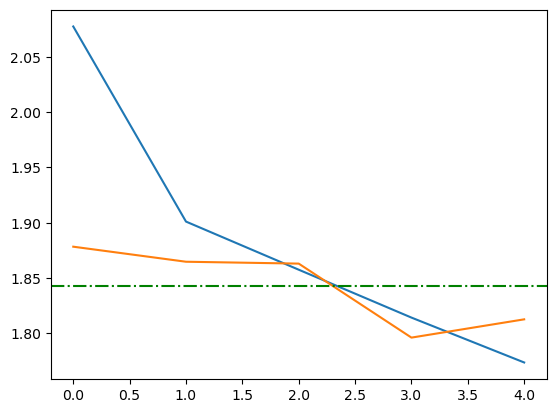

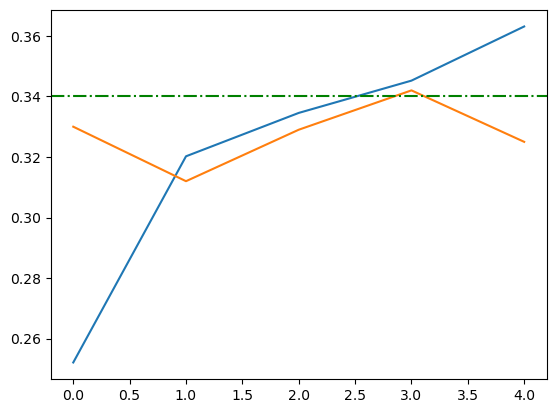

63/63 [==============================] - 0s 1ms/step


array([[102,  16,  23,  10,  14,   8,   4,  11,  57,  32],
       [  3,  80,   3,  11,   4,   3,  10,   3,  12,  23],
       [ 25,  12,  74,  30,  46,  40,  17,  22,  21,   9],
       [  0,   3,   0,   1,   0,   3,   1,   2,   0,   2],
       [  8,  16,  65,  42,  95,  38,  78,  51,   5,   9],
       [  0,  11,  22,  54,  13,  60,  21,  20,  14,   3],
       [  4,   9,  11,  24,  20,  19,  57,   6,   1,  12],
       [  9,   7,  10,  14,  14,  13,   2,  75,   5,  15],
       [ 31,  26,   6,   6,   6,   8,   3,   6,  65,  34],
       [  3,  19,   2,   5,   2,   2,   1,   5,  10,  71]])

In [8]:
test_loss, test_acc = mod1.evaluate(X_test, y_test)

a_name='sparse_categorical_accuracy'
val_a_name = 'val_' + a_name
plt.plot(fh.history['loss'])
plt.plot(fh.history['val_loss'])
plt.axhline(y=test_loss, color='green', linestyle='-.',label = 'test')
plt.show()

plt.plot(fh.history[a_name])
plt.plot(fh.history[val_a_name])
plt.axhline(y=test_acc, color='green', linestyle='-.',label = 'test')
plt.show()

mod1_pred = mod1.predict(X_test)           # probabilities    
y_pred    = np.argmax(mod1_pred, axis=1)   # classes with max prob (= labels)
cm=confusion_matrix(y_pred, y_test)
cm

**Message:**

There are several ways to improve this (more data, hyperparameters etc.)

However, achieving higher (test and valdiation) accuracy on flattened images will generally be difficult $\to$ change network architecture


# Convolutional Neural Networks (CNN)
... a picture and some jargon

![CNN_convlayer](https://upload.wikimedia.org/wikipedia/commons/6/68/Conv_layer.png)
(from wikipedia.org)

## New layers: Filters and Pools

![filter](https://wiki.tum.de/download/attachments/23572254/cnn6.png)
(from wiki.tum.de)

- **input layer:** image shape [width, height, 3 (RGB)]
- **convolutional layer** (Conv): n filters e.g (n,3,3,3)

  - detect pattern (e.g. horizontal, vertical, diagonal lines)
  - have the same depth as input
  - several filter per layer: different filters applied to same spatial location in image

- **pooling filter** (Pool)
  - spatially downsampling, depth stay the same (e.g. max or average)

- **fully conncted layer** (Dense)
  - connect all previous nodes

Typical structures: Input - Conv/Relu - Conv/Relu - Pool - Conv/Relu - ... - Dense

Lower layers: Primitive "concepts",  Higher layers: Higher order "concepts" 


# CNN: tensorflow implementation

In [9]:
nc = np.unique(y_train).size  # number of classes / labels in training set
l_name = 'sparse_categorical_crossentropy'
a_name = 'sparse_categorical_accuracy'

input_shape = X_train.shape[1:]

print('X_train.shape:     ', X_train.shape)
print('input_shape:       ', input_shape)
print('number of classes: ', nc)

model = tf.keras.models.Sequential(name='cifar_CNN_3')

# Convolutional layers
model.add(tf.keras.layers.InputLayer(input_shape))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='1st_conv'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='2nd_conv'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# as before
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu', name='last'))
model.add(tf.keras.layers.Dense(nc, activation='softmax', name='output'))

model.compile(optimizer='adam', loss=l_name, metrics=a_name)
model.summary()

X_train.shape:      (10000, 32, 32, 3)
input_shape:        (32, 32, 3)
number of classes:  10
Model: "cifar_CNN_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1st_conv (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 2nd_conv (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 32)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1152)              0         
                           

## CNN: fitting, GPUs and batch size

The following cell will fit the model. This will take some time - especially without dedicated hardware (e.g. GPU) or further optimization (improved algorithm).

Please start the cell. While it runs I will provide some explanations what is going on under the hood.

In [10]:
fh = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

model_fn   = model.name + '.h5'  
history_fn = model.name + '_history.npy'

hist=fh.history
model.save(model_fn)
np.save(history_fn, hist)

Epoch 1/10
282/282 [==============================] - 3s 7ms/step - loss: 1.9088 - sparse_categorical_accuracy: 0.2970 - val_loss: 1.7706 - val_sparse_categorical_accuracy: 0.3610
Epoch 2/10
282/282 [==============================] - 2s 6ms/step - loss: 1.5554 - sparse_categorical_accuracy: 0.4416 - val_loss: 1.5053 - val_sparse_categorical_accuracy: 0.4570
Epoch 3/10
282/282 [==============================] - 2s 6ms/step - loss: 1.3857 - sparse_categorical_accuracy: 0.5047 - val_loss: 1.3393 - val_sparse_categorical_accuracy: 0.5410
Epoch 4/10
282/282 [==============================] - 2s 6ms/step - loss: 1.2458 - sparse_categorical_accuracy: 0.5532 - val_loss: 1.3732 - val_sparse_categorical_accuracy: 0.5270
Epoch 5/10
282/282 [==============================] - 2s 8ms/step - loss: 1.1600 - sparse_categorical_accuracy: 0.5903 - val_loss: 1.2932 - val_sparse_categorical_accuracy: 0.5430
Epoch 6/10
282/282 [==============================] - 2s 7ms/step - loss: 1.0770 - sparse_categorica

/home/manke/localenv/anaconda/miniconda3/envs/ML2024/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Loading Model and History

In [11]:
#%%script echo Run after new start
model_fn   = 'cifar_CNN_3.h5'
history_fn = 'cifar_CNN_3_history.npy'

model = tf.keras.models.load_model(model_fn)
hist = np.load(history_fn, allow_pickle=True).item()

## Evaluations

Evaluate Model: cifar_CNN_3
63/63 [==============================] - 0s 3ms/step - loss: 1.2114 - sparse_categorical_accuracy: 0.5980


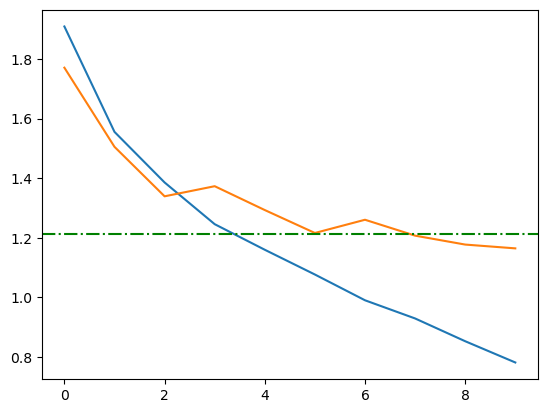

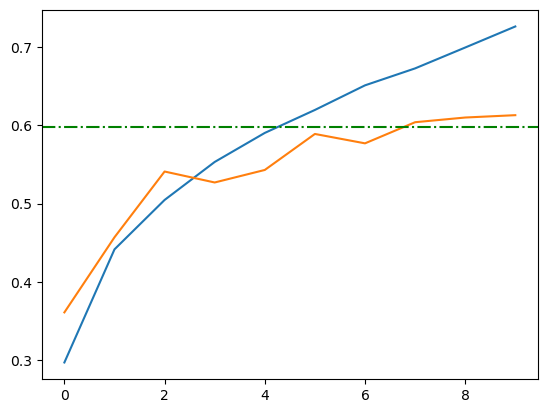

In [12]:
# For this to work the test_data needs to be loaded and normalized !!!
print('Evaluate Model:',model.name)
test_loss, test_acc = model.evaluate(X_test, y_test)

a_name='sparse_categorical_accuracy'
val_a_name = 'val_' + a_name
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.axhline(y=test_loss, color='green', linestyle='-.',label = 'test')
plt.show()

plt.plot(hist[a_name])
plt.plot(hist[val_a_name])
plt.axhline(y=test_acc, color='green', linestyle='-.',label = 'test')
plt.show()

**Message:** An improvement over the previous network.

**Discussion:** What could be further improvements?

## Predictions

**Task:** Explore some predictions on the test data

1/1 [==============================] - 0s 79ms/step


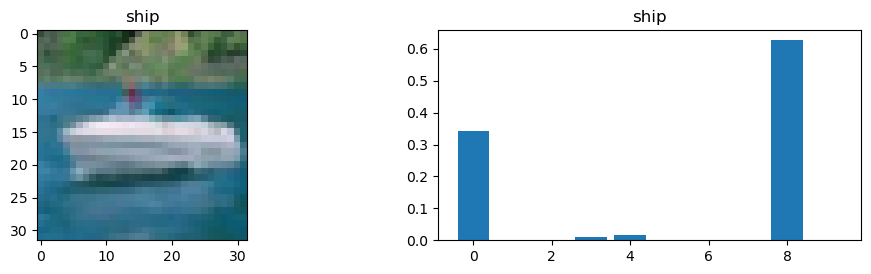

63/63 [==============================] - 0s 3ms/step


array([[116,   8,  16,   4,  10,   5,   1,   2,  12,   7],
       [  1, 131,   3,   3,   3,   0,   5,   1,  12,  15],
       [  6,   2, 103,  16,  26,  13,   4,   7,   4,   1],
       [  4,   4,  25,  91,  22,  55,  22,  15,   6,   8],
       [  1,   1,  16,  20,  97,   8,  10,  12,   1,   0],
       [  1,   4,  23,  33,  14,  93,   4,  32,   0,   1],
       [  3,   2,  11,  11,  21,   3, 144,   1,   0,   4],
       [  5,   1,   8,   5,  14,   7,   1, 121,   1,   5],
       [ 37,  14,   4,   8,   6,   5,   1,   3, 146,  15],
       [ 11,  32,   7,   6,   1,   5,   2,   7,   8, 154]])

In [13]:
idx=2
X = X_test[idx]
X = np.expand_dims(X, axis=0)

pred = model.predict(X)
i_max=np.argmax(pred)
true_lab=class_names[y_test[idx][0]]
pred_lab=class_names[i_max]

plt.figure(figsize=(12,6))
ax = plt.subplot(2,2,1)
plt.imshow(X_test[idx]) 
plt.title(true_lab)

ax = plt.subplot(2,2,2)
plt.bar(range(10), pred[0])
plt.title(pred_lab)
plt.show()

model_pred = model.predict(X_test)          # probabilities    
y_pred    = np.argmax(model_pred, axis=1)   # classes with max prob (= labels)
cm=confusion_matrix(y_pred, y_test)
cm

# A closer look at layers

Motivation: Understand prediction in terms of layered "concepts"

## The last layer

The goal of the added convolutional layers is to obtain a better representation of the image data by representing spatial features (edges etc.). If this is successful then we would expect better separation properties in the penultimate layer (last before output layer).

X shapes:  (1000, 3072) (1000, 128)
PCA Shapes:  (1000, 2) (1000, 2)


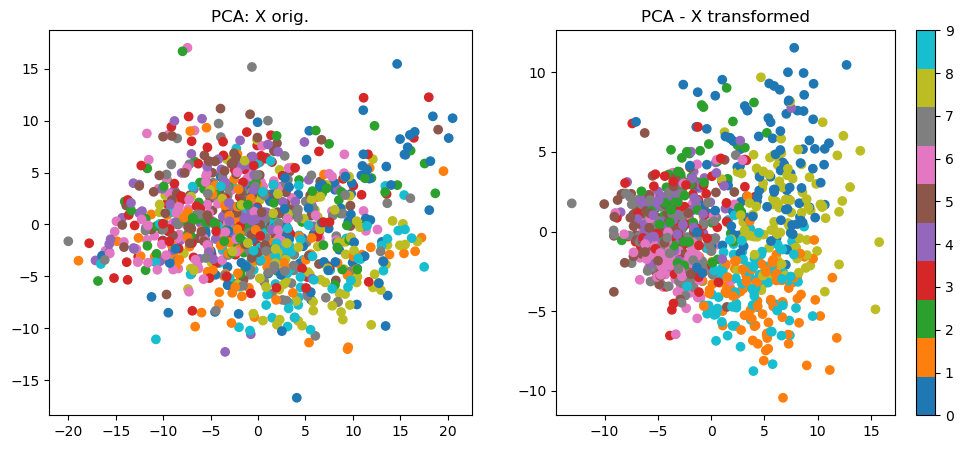

In [17]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# define new model: X -> last layer
layer_name = 'last'
layer_model = tf.keras.Model(inputs=model.input,
                             outputs=model.get_layer(layer_name).output)

nr = 1000
y=y_train[:nr]
X=X_train[:nr]
X_lay = layer_model(X).numpy()   # last layer representation of X

X = X.reshape(nr,-1)                # flatten each image
X_lay = X_lay.reshape(nr,-1)        # flatten each image (redundant)

print('X shapes: ',X.shape, X_lay.shape)

#X_pca = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)
#X_lay_pca = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_lay)

X_pca = PCA(n_components = 2).fit_transform(X)
X_lay_pca = PCA(n_components = 2).fit_transform(X_lay)
print('PCA Shapes: ',X_pca.shape, X_lay_pca.shape)

plt.figure(figsize=(12, 5))
cm = plt.get_cmap('tab10')

ax = plt.subplot(1, 2, 1)
plt.scatter( X_pca[:,0], X_pca[:,1] , c=y, cmap=cm)
plt.title('PCA: X orig.')

ax = plt.subplot(1, 2, 2)
plt.scatter( X_lay_pca[:,0], X_lay_pca[:,1] , c=y, cmap=cm)
plt.title('PCA - X transformed')

plt.colorbar()
plt.show()